In [1]:
import glob
import os
import pickle
from scipy.stats import bernoulli

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
from xgboost import XGBRegressor

import xgboost as xgb
import scikitplot as skplt
import scipy.stats as st

# from google.colab import drive
# # mount google drive information in a google colaboratory directory
# drive.mount('/content/gdrive')

# path = r'gdrive/My Drive/Trabajos DS/Data/' # path
path = 'home\Documents\Personal\MIMYANALYTICS\TESIS\TESIS\datasets' #C:\Users\dlongas

In [2]:
#Funciones Útiles
def plot_roc(label, pred):
    """
    Grafica curva ROC
    """
    fpr, tpr, thresholds = roc_curve(label, pred)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, label="AUC %.4f" % roc_auc_score(label, pred))
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend(loc="lower right")
    # show the plot
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    
def gap_metricas(prior_mujer, y_proba, y_test, gap = .09):
        
    threshold_m = prior_mujer + gap
    threshold_h = prior_mujer - gap

    prec_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_proba > threshold_m).sum()
    recall_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_test==1).sum()
    f1_m = prec_m * recall_m * 2 / (prec_m + recall_m )

    prec_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_proba < threshold_h).sum()
    recall_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_test == 0).sum()
    f1_h = prec_h * recall_h * 2 / (prec_h + recall_h )

    print("Porcentaje del total: "+str(round(100*len(y_proba[(y_proba>threshold_m) | (y_proba<threshold_h)])/len(y_proba),2)))
    print("Hombres: precision = %.4f - recall = %.4f - f1 = %.4f " % (prec_h, recall_h, f1_h))
    print("Mujeres: precision = %.4f - recall = %.4f - f1 = %.4f "% (prec_m, recall_m, f1_m)) 
    
    
def precision_recall_curve_hombre(y_test,y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test,y_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, label = 'precision (label = 1)')
    plt.plot(thresholds, recall, label = 'recall (label = 1)')   
    plt.xlabel('thresholds (score= prob hombre)')
    plt.legend(loc="lower left")
    plt.show()
    
    
def precision_recall_curve_mujer(y_test,y_proba):
    precision, recall, thresholds = precision_recall_curve(1 - y_test, 1- y_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, label = 'precision (label = 0)')
    plt.plot(thresholds, recall, label = 'recall (label = 0)')   
    plt.xlabel('thresholds (score= prob mujer)')
    plt.legend(loc="lower left")
    plt.show()
    
    
def precision_metricas(prior_mujer, y_proba, y_test, prec_esperada = .80, hombre_eval=1):
    
    for gap in list(np.linspace(0, 0.5, 100)):
        threshold_m = prior_mujer + gap
        threshold_h = prior_mujer - gap
        if((threshold_m > 1)|(threshold_h<0)):
            print('No se pudo encontrar datos con ese nivel de precisión.')
            break
        else:
            prec_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_proba > threshold_m).sum()
            recall_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_test==1).sum()
            f1_m = prec_m * recall_m * 2 / (prec_m + recall_m )

            prec_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_proba < threshold_h).sum()
            recall_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_test == 0).sum()
            f1_h = prec_h * recall_h * 2 / (prec_h + recall_h )
            
            if(((hombre_eval==1)&(prec_h>=prec_esperada))|((hombre_eval==0)&(prec_m>=prec_esperada))):
               print("Porcentaje del total: "+str(round(100*len(y_proba[(y_proba>threshold_m) | (y_proba<threshold_h)])/len(y_proba),2)))
               print("Hombres: precision = %.4f - recall = %.4f - f1 = %.4f " % (prec_h, recall_h, f1_h))
               print("Mujeres: precision = %.4f - recall = %.4f - f1 = %.4f "% (prec_m, recall_m, f1_m))
               break
    if (gap==0.5):
        print('No se pudo encontrar datos con ese nivel de precisión.')

        
def precision_top(y_proba, y_test, top=1000):    
    ref=list(y_proba)
    ref.sort()

    prec_m = ((y_proba>=ref[(-1*top)]) & (y_test==1)).sum() * 1. / (y_proba>=ref[(-1*top)]).sum()
    recall_m = ((y_proba>=ref[(-1*top)]) & (y_test==1)).sum() * 1. / (y_test==1).sum()

    prec_h = ((y_proba<=ref[top]) & (y_test==0)).sum() * 1. / (y_proba<=ref[top]).sum()
    recall_h = ((y_proba<=ref[top]) & (y_test==0)).sum() * 1. / (y_test==0).sum()

    print("Porcentaje del total: "+str(round(100*((len(y_proba[y_proba<=ref[top]])+
                                                   len(y_proba[y_proba>=ref[(-1*top)]]))/len(y_proba)),2)))
    print("Hombres: precision = %.4f - recall = %.4f " % (prec_h, recall_h))
    print("Mujeres: precision = %.4f - recall = %.4f "% (prec_m, recall_m))
    

In [3]:
#Descargo dataset final user agent con feature engeneering
df1 = pd.read_csv('df_final_ua.csv')
df1 = df1.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df1.shape)
df1.head()

Dataset Size (88804, 63)


,fem,Is_pc,Is_mobile,Is_tablet,OS_Android,OS_Linux,OS_Mac OS X,OS_Windows,OS_iOS,navegador_Brand_browser,...,marca_Apple,marca_Huawei,marca_LG,marca_Motorola,marca_Samsung,marca_XiaoMi,Antiguedad_ancient,Antiguedad_new,Antiguedad_old,device_idx
0,1.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
1,0.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2.0
2,0.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3.0
3,0.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.0
4,0.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,5.0


In [4]:
#Descargo dataset final dominios con feature engeneering
df2 = pd.read_csv('df_final_domains_prueba.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df2.shape)
df2.head()

Dataset Size (99469, 18)


,fem,domain_type_Alimentos,domain_type_Automovil,domain_type_Busqueda_Laboral,domain_type_Consumo,domain_type_Deportes,domain_type_Educacion,domain_type_Entretenimiento,domain_type_Familia_y_Hogar,domain_type_Farandula,domain_type_Inmobiliaria,domain_type_Linea_Movil,domain_type_Noticias,domain_type_Otros,domain_type_Salud,domain_type_Tramites_Bancarios,domain_type_Viajes,device_idx
0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0


In [5]:
#Descargo dataset final dominios con feature engeneering
df3 = pd.read_csv('df_final_urls.csv')
df3 = df3.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df3.shape)
df3.head()

Dataset Size (98491, 63)


,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,...,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop,fem
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0


In [6]:
#Uno por device id a ambos
df = pd.merge(df1, df2, how='inner', on='device_idx')
df = df.rename(columns={'fem_x':'fem'})
df = df.drop('fem_y', axis=1)
df= df.drop_duplicates()
print(df.shape)
print(df.columns)

df = pd.merge(df, df3, how='inner', on='device_idx')
df = df.rename(columns={'fem_x':'fem'})
df = df.drop('fem_y', axis=1)
df= df.drop_duplicates()
print(df.shape)
print(df.columns)
pd.options.display.max_columns = None #veo todas las columnas
df.head()

(88580, 79)
Index(['fem', 'Is_pc', 'Is_mobile', 'Is_tablet', 'OS_Android', 'OS_Linux',
       'OS_Mac OS X', 'OS_Windows', 'OS_iOS', 'navegador_Brand_browser',
       'navegador_Chrome', 'navegador_Edge', 'navegador_Firefox',
       'navegador_Safari', 'navegador_SocialApp', 'modelo_Moto G (5',
       'modelo_Moto G (5S', 'modelo_Samsung SM-A015M',
       'modelo_Samsung SM-A105M', 'modelo_Samsung SM-A107M',
       'modelo_Samsung SM-A205G', 'modelo_Samsung SM-A207M',
       'modelo_Samsung SM-A217M', 'modelo_Samsung SM-A305G',
       'modelo_Samsung SM-A307G', 'modelo_Samsung SM-A315G',
       'modelo_Samsung SM-A505G', 'modelo_Samsung SM-A515F',
       'modelo_Samsung SM-G532M', 'modelo_Samsung SM-G570M',
       'modelo_Samsung SM-G610M', 'modelo_Samsung SM-G950F',
       'modelo_Samsung SM-J260M', 'modelo_Samsung SM-J400M',
       'modelo_Samsung SM-J415G', 'modelo_Samsung SM-J600G',
       'modelo_Samsung SM-J610G', 'modelo_Samsung SM-J700M',
       'modelo_Samsung SM-J701M', 'mode

,fem,Is_pc,Is_mobile,Is_tablet,OS_Android,OS_Linux,OS_Mac OS X,OS_Windows,OS_iOS,navegador_Brand_browser,navegador_Chrome,navegador_Edge,navegador_Firefox,navegador_Safari,navegador_SocialApp,modelo_Moto G (5,modelo_Moto G (5S,modelo_Samsung SM-A015M,modelo_Samsung SM-A105M,modelo_Samsung SM-A107M,modelo_Samsung SM-A205G,modelo_Samsung SM-A207M,modelo_Samsung SM-A217M,modelo_Samsung SM-A305G,modelo_Samsung SM-A307G,modelo_Samsung SM-A315G,modelo_Samsung SM-A505G,modelo_Samsung SM-A515F,modelo_Samsung SM-G532M,modelo_Samsung SM-G570M,modelo_Samsung SM-G610M,modelo_Samsung SM-G950F,modelo_Samsung SM-J260M,modelo_Samsung SM-J400M,modelo_Samsung SM-J415G,modelo_Samsung SM-J600G,modelo_Samsung SM-J610G,modelo_Samsung SM-J700M,modelo_Samsung SM-J701M,modelo_Samsung SM-J710MN,modelo_XiaoMi Redmi Note 7,modelo_XiaoMi Redmi Note 8,modelo_iPhone,modelo_moto e5,modelo_moto e5 play,VOS_Android 10,VOS_Android 6,VOS_Android 7,VOS_Android 8,VOS_Android 9,VOS_Windows 10,VOS_Windows 7,VOS_Windows 8,marca_Apple,marca_Huawei,marca_LG,marca_Motorola,marca_Samsung,marca_XiaoMi,Antiguedad_ancient,Antiguedad_new,Antiguedad_old,device_idx,domain_type_Alimentos,domain_type_Automovil,domain_type_Busqueda_Laboral,domain_type_Consumo,domain_type_Deportes,domain_type_Educacion,domain_type_Entretenimiento,domain_type_Familia_y_Hogar,domain_type_Farandula,domain_type_Inmobiliaria,domain_type_Linea_Movil,domain_type_Noticias,domain_type_Otros,domain_type_Salud,domain_type_Tramites_Bancarios,domain_type_Viajes,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop
0,1.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [8]:
#Null values
pd.options.display.max_rows = None
print(df.isnull().sum()) #There are no null values

fem                               0
Is_pc                             0
Is_mobile                         0
Is_tablet                         0
OS_Android                        0
OS_Linux                          0
OS_Mac OS X                       0
OS_Windows                        0
OS_iOS                            0
navegador_Brand_browser           0
navegador_Chrome                  0
navegador_Edge                    0
navegador_Firefox                 0
navegador_Safari                  0
navegador_SocialApp               0
modelo_Moto G (5                  0
modelo_Moto G (5S                 0
modelo_Samsung SM-A015M           0
modelo_Samsung SM-A105M           0
modelo_Samsung SM-A107M           0
modelo_Samsung SM-A205G           0
modelo_Samsung SM-A207M           0
modelo_Samsung SM-A217M           0
modelo_Samsung SM-A305G           0
modelo_Samsung SM-A307G           0
modelo_Samsung SM-A315G           0
modelo_Samsung SM-A505G           0
modelo_Samsung SM-A515F     

In [7]:
variables_dep = []
for col in df.columns:
    if col != 'fem': 
        if col != 'device_idx':
            variables_dep.append(col)        
variables_dep

['Is_pc',
 'Is_mobile',
 'Is_tablet',
 'OS_Android',
 'OS_Linux',
 'OS_Mac OS X',
 'OS_Windows',
 'OS_iOS',
 'navegador_Brand_browser',
 'navegador_Chrome',
 'navegador_Edge',
 'navegador_Firefox',
 'navegador_Safari',
 'navegador_SocialApp',
 'modelo_Moto G (5',
 'modelo_Moto G (5S',
 'modelo_Samsung SM-A015M',
 'modelo_Samsung SM-A105M',
 'modelo_Samsung SM-A107M',
 'modelo_Samsung SM-A205G',
 'modelo_Samsung SM-A207M',
 'modelo_Samsung SM-A217M',
 'modelo_Samsung SM-A305G',
 'modelo_Samsung SM-A307G',
 'modelo_Samsung SM-A315G',
 'modelo_Samsung SM-A505G',
 'modelo_Samsung SM-A515F',
 'modelo_Samsung SM-G532M',
 'modelo_Samsung SM-G570M',
 'modelo_Samsung SM-G610M',
 'modelo_Samsung SM-G950F',
 'modelo_Samsung SM-J260M',
 'modelo_Samsung SM-J400M',
 'modelo_Samsung SM-J415G',
 'modelo_Samsung SM-J600G',
 'modelo_Samsung SM-J610G',
 'modelo_Samsung SM-J700M',
 'modelo_Samsung SM-J701M',
 'modelo_Samsung SM-J710MN',
 'modelo_XiaoMi Redmi Note 7',
 'modelo_XiaoMi Redmi Note 8',
 'model

**Number of DEVICES by target variable**

In [12]:
tmp = df.groupby(['fem']).nunique()[['device_idx']]
tmp['porc'] = df['fem'].value_counts(normalize=True) * 100
tmp['Gender'] = np.where(tmp.index==0, 'Male', 'Female')
tmp.rename(columns={'device_idx':'# Devices',
                    'porc':'% Devices'})

,# Devices,% Devices,Gender
fem,,,
0.0,41275,47.094366,Male
1.0,46392,52.905634,Female


In [13]:
#VEO QUE VARIABLES QUEDAN COMO INPUTS A LOS MODELOS
#Regresión Logistica con stats model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import statsmodels.api as sm

logit_model1 = sm.Logit(y, X)
result=logit_model1.fit()
print(result.summary()) #ver p>z, si es menor a 0.005. es significativo el coef. Ademas el 0 no debe estasr en el int de conf

Optimization terminated successfully.
         Current function value: 0.661369
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    fem   No. Observations:                87881
Model:                          Logit   Df Residuals:                    87744
Method:                           MLE   Df Model:                          136
Date:                Sat, 22 May 2021   Pseudo R-squ.:                 0.04352
Time:                        16:49:44   Log-Likelihood:                -58122.
converged:                       True   LL-Null:                       -60766.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Is_pc                              0.0644      0.199      0.324     

C:\Users\dlongas\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


In [17]:
cols=['OS_Android',
 'OS_Linux',
  'navegador_Firefox',
 'navegador_SocialApp',
 'modelo_Samsung SM-A105M',
 'modelo_Samsung SM-A205G',
 'modelo_Samsung SM-A307G',
 'modelo_Samsung SM-A505G',
 'modelo_Samsung SM-A515F',
 'modelo_Samsung SM-J400M',
 'modelo_Samsung SM-J600G',
 'modelo_Samsung SM-J610G',
 'modelo_Samsung SM-J700M',
 'modelo_XiaoMi Redmi Note 7',
 'modelo_moto e5',
 'VOS_Windows 10',
 'VOS_Windows 7',
 'VOS_Windows 8',
 'marca_Samsung',
 'marca_XiaoMi',
 'domain_type_Alimentos',
 'domain_type_Busqueda_Laboral',
 'domain_type_Consumo',
 'domain_type_Deportes',
 'domain_type_Familia_y_Hogar',
 'domain_type_Farandula',
 'domain_type_Inmobiliaria',
 'domain_type_Linea_Movil',
 'domain_type_Noticias',
 'domain_type_Otros',
 'domain_type_Viajes',
 '0221',
 'Otros',
 'almundo',
 'ambito',
 'animeflv',
 'ausa',
 'autocosmos',
 'buenosaires',
 'bumeran',
 'contextotucuman',
 'credisense',
 'creditosparatodos',
 'cronista',
 'curriculumvitaeempresarial',
 'depor',
 'disco',
 'elcomercio',
 'empleosit',
 'futbollibre',
 'gardenlife',
 'gba',
 'infotechnology',
 'jumbo',
 'losandes',
 'movistar',
 'mundoazulgrana',
 'nissan',
 'prestamosparatodos',
 'pronto',
 'ratingcero',
 'renault',
 'rojadirectatv',
 'sancorsalud',
 'starbucksrewards',
 'swarovski',
 'toyota',
 'veadigital',
 'ypf',
 'zonajobs',
 'zonaprop']
variables_dep_final =df[cols]
#variables_dep_final

In [8]:
df_ = df[['fem','OS_Android',
 'OS_Linux',
  'navegador_Firefox',
 'navegador_SocialApp',
 'modelo_Samsung SM-A105M',
 'modelo_Samsung SM-A205G',
 'modelo_Samsung SM-A307G',
 'modelo_Samsung SM-A505G',
 'modelo_Samsung SM-A515F',
 'modelo_Samsung SM-J400M',
 'modelo_Samsung SM-J600G',
 'modelo_Samsung SM-J610G',
 'modelo_Samsung SM-J700M',
 'modelo_XiaoMi Redmi Note 7',
 'modelo_moto e5',
 'VOS_Windows 10',
 'VOS_Windows 7',
 'VOS_Windows 8',
 'marca_Samsung',
 'marca_XiaoMi',
 'domain_type_Alimentos',
 'domain_type_Busqueda_Laboral',
 'domain_type_Consumo',
 'domain_type_Deportes',
 'domain_type_Familia_y_Hogar',
 'domain_type_Farandula',
 'domain_type_Inmobiliaria',
 'domain_type_Linea_Movil',
 'domain_type_Noticias',
 'domain_type_Otros',
 'domain_type_Viajes',
 '0221',
 'Otros',
 'almundo',
 'ambito',
 'animeflv',
 'ausa',
 'autocosmos',
 'buenosaires',
 'bumeran',
 'contextotucuman',
 'credisense',
 'creditosparatodos',
 'cronista',
 'curriculumvitaeempresarial',
 'depor',
 'disco',
 'elcomercio',
 'empleosit',
 'futbollibre',
 'gardenlife',
 'gba',
 'infotechnology',
 'jumbo',
 'losandes',
 'movistar',
 'mundoazulgrana',
 'nissan',
 'prestamosparatodos',
 'pronto',
 'ratingcero',
 'renault',
 'rojadirectatv',
 'sancorsalud',
 'starbucksrewards',
 'swarovski',
 'toyota',
 'veadigital',
 'ypf',
 'zonajobs',
 'zonaprop']]
df_.to_csv('df_tercer_modelo.csv')
print(df_.shape)
df_.head()

(87881, 72)


,fem,OS_Android,OS_Linux,navegador_Firefox,navegador_SocialApp,modelo_Samsung SM-A105M,modelo_Samsung SM-A205G,modelo_Samsung SM-A307G,modelo_Samsung SM-A505G,modelo_Samsung SM-A515F,modelo_Samsung SM-J400M,modelo_Samsung SM-J600G,modelo_Samsung SM-J610G,modelo_Samsung SM-J700M,modelo_XiaoMi Redmi Note 7,modelo_moto e5,VOS_Windows 10,VOS_Windows 7,VOS_Windows 8,marca_Samsung,marca_XiaoMi,domain_type_Alimentos,domain_type_Busqueda_Laboral,domain_type_Consumo,domain_type_Deportes,domain_type_Familia_y_Hogar,domain_type_Farandula,domain_type_Inmobiliaria,domain_type_Linea_Movil,domain_type_Noticias,domain_type_Otros,domain_type_Viajes,0221,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,disco,elcomercio,empleosit,futbollibre,gardenlife,gba,infotechnology,jumbo,losandes,movistar,mundoazulgrana,nissan,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,starbucksrewards,swarovski,toyota,veadigital,ypf,zonajobs,zonaprop
0,1.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [19]:
# defino X e y
# get the dependent and the independents variables
X=df[cols]
y = df['fem']

- Train: subconjunto para entrenar el modelo.
- Test: subconjunto para verificar que el modelo reproduce los resultados deseados.

In [20]:
# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

In [21]:
Xtrain.shape

(70304, 71)

Debido a problemas de escalas diferentes en distintas variables se suele estandarizar los datos, es decir restarle la media y dividir sobre la varianza.

In [22]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

**MODELOS**

The problem involves a binary response variable (0: Male; 1: Female) so classification techniques need to be used to get the suitable model.

Logistic Regression, Random Forest and XGBoost will be used to predict if a devices is going to be female or not.

The main metrics which will be considered are Accuracy and Recall.

***Accuracy***: Is the fraction of all positive and negative instances that the classifier correctly identifies as positive and negative respectively. ((TN+TP)/(TN+TP+FN+FP))

***Recall***: Is the fraction of all positive instances that the classifier correctLy indentifies as positive. (TP/(TP+FN)) 

***Precision***: Is the fraction of all positive predictions that are actually positive. (TP/(TP+FP)) 

***AUC***: The AUC provides an aggregate measure of performance across all possible classification thresholds. One way to interpret the AUC is as the probability that the model ranks a random positive example higher than a random negative example.   

The most imoprtant task in this problem is to make a correct prediction about user's device gender. 

**Baseline**

A fundamental aspect to consider before running the models is to compare them with a baseline. In this case, a basic Naive Bayes is going to be used.

In [23]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(Xtrain, ytrain)

#Predict the response for test dataset
y_pred = gnb.predict(Xtest)

y_proba = gnb.predict_proba(Xtest)[:,1]

In [24]:
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Accuracy: 0.5910564942823008


Accuracy  :  0.591
Recall  :  0.854
F1 - Score:  0.687
Precision  :  0.574


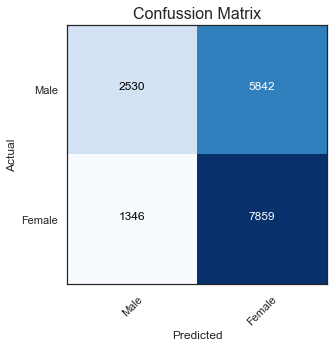

In [26]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, y_pred) #para comprobar lo predicho con lo real
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("F1 - Score: ",round(2*(pre*rec/(pre+rec)),3))
print("Precision  : ", pre)

In [188]:
costos_fem=np.array([[0,0.000001],
       [0.00000273,-0.00000237]])
matrizcostos = cnf_matrix*costos_fem
print(matrizcostos)
print(np.float(matrizcostos[0][0]))
print(np.float(matrizcostos[0][1]))
print(np.float(matrizcostos[1][0]))
print(np.float(matrizcostos[1][1]))

[[ 0.    0.01]
 [ 0.   -0.02]]
0.0
0.005771999999999999
0.00445263
-0.017950380000000002


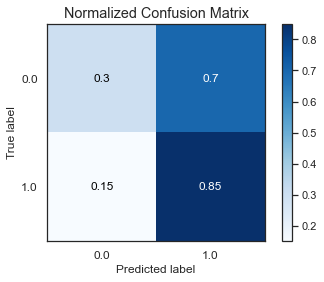

In [27]:
predictions = cross_val_predict(gnb, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

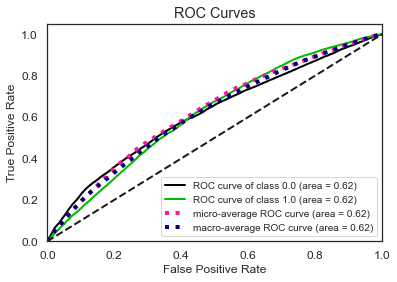

In [28]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(gnb, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_roc(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

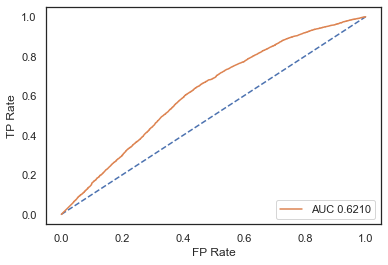

In [29]:
plot_roc(ytest,y_proba)

In [30]:
logreg1=LogisticRegression()
logreg1.fit(Xtrain,ytrain)
pred1 = logreg1.predict(Xtest)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg1.score(Xtest, ytest)))

Accuracy of logistic regression classifier on test set: 0.61228


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(ytest,pred1)
print(confusion_matrix)

total=sum(sum(confusion_matrix))
sensitivity1 = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity1 )

specificity1 = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity1)

fpr, tpr, thresholds = roc_curve(ytest, pred1)
a=auc(fpr,tpr)
print("Area under the curve:",a)

[[3433 4939]
 [1876 7329]]
Sensitivity :  0.6466377848935769
Specificity :  0.5974078904466906
Area under the curve: 0.603127526300778


In [32]:
from sklearn.metrics import classification_report
print(classification_report(ytest, pred1))

              precision    recall  f1-score   support

         0.0       0.65      0.41      0.50      8372
         1.0       0.60      0.80      0.68      9205

    accuracy                           0.61     17577
   macro avg       0.62      0.60      0.59     17577
weighted avg       0.62      0.61      0.60     17577



In [33]:
#Regresion Logistica nuevamente , con variables significativas
cols=['OS_Android',
 'OS_Linux',
  'navegador_Firefox',
 'navegador_SocialApp',
 'modelo_Samsung SM-A105M',
 'modelo_Samsung SM-A205G',
 'modelo_Samsung SM-A307G',
 'modelo_Samsung SM-A505G',
 'modelo_Samsung SM-A515F',
 'modelo_Samsung SM-J400M',
 'modelo_Samsung SM-J600G',
 'modelo_Samsung SM-J610G',
 'modelo_Samsung SM-J700M',
 'modelo_XiaoMi Redmi Note 7',
 'modelo_moto e5',
 'VOS_Windows 10',
 'VOS_Windows 7',
 'VOS_Windows 8',
 'marca_Samsung',
 'marca_XiaoMi',
 'domain_type_Alimentos',
 'domain_type_Busqueda_Laboral',
 'domain_type_Consumo',
 'domain_type_Deportes',
 'domain_type_Familia_y_Hogar',
 'domain_type_Farandula',
 'domain_type_Inmobiliaria',
 'domain_type_Linea_Movil',
 'domain_type_Noticias',
 'domain_type_Otros',
 'domain_type_Viajes',
 '0221',
 'Otros',
 'almundo',
 'ambito',
 'animeflv',
 'ausa',
 'autocosmos',
 'buenosaires',
 'bumeran',
 'contextotucuman',
 'credisense',
 'creditosparatodos',
 'cronista',
 'curriculumvitaeempresarial',
 'depor',
 'disco',
 'elcomercio',
 'empleosit',
 'futbollibre',
 'gardenlife',
 'gba',
 'infotechnology',
 'jumbo',
 'losandes',
 'movistar',
 'mundoazulgrana',
 'nissan',
 'prestamosparatodos',
 'pronto',
 'ratingcero',
 'renault',
 'rojadirectatv',
 'sancorsalud',
 'starbucksrewards',
 'swarovski',
 'toyota',
 'veadigital',
 'ypf',
 'zonajobs',
 'zonaprop'] 
X=df[cols]
y=df['fem']

In [34]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = .2, random_state=10)
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

In [35]:
logit_model2=sm.Logit(ytrain,Xtrain)
result=logit_model2.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.662850
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    fem   No. Observations:                70304
Model:                          Logit   Df Residuals:                    70233
Method:                           MLE   Df Model:                           70
Date:                Sat, 22 May 2021   Pseudo R-squ.:                 0.04148
Time:                        16:53:37   Log-Likelihood:                -46601.
converged:                       True   LL-Null:                       -48618.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0331      0.020      1.636      0.102      -0.007       0.073
x2            -0.0231      0.

In [36]:
logreg2=LogisticRegression(C=0.001)
logreg2.fit(Xtrain,ytrain)
pred2 = logreg2.predict(Xtest)
print(logreg2)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg2.score(Xtest, ytest)))

from sklearn.metrics import confusion_matrix
confusion_matrix2 = confusion_matrix(ytest,pred2)
print(confusion_matrix2)

sensitivity2 = confusion_matrix2[0,0]/(confusion_matrix2[0,0]+confusion_matrix2[1,0])
print('Sensitivity : ', sensitivity2 )

specificity2 = confusion_matrix2[1,1]/(confusion_matrix2[1,1]+confusion_matrix2[0,1])
print('Specificity : ', specificity2)

fpr, tpr, thresholds = roc_curve(ytest, pred2)
a=auc(fpr,tpr)
print("Area under the curve:",a)

from sklearn.metrics import classification_report
print(classification_report(ytest, pred2))

LogisticRegression(C=0.001)
Accuracy of logistic regression classifier on test set: 0.60511
[[3282 4947]
 [1994 7354]]
Sensitivity :  0.6220621683093253
Specificity :  0.597837574180961
Area under the curve: 0.5927628673508372
              precision    recall  f1-score   support

         0.0       0.62      0.40      0.49      8229
         1.0       0.60      0.79      0.68      9348

    accuracy                           0.61     17577
   macro avg       0.61      0.59      0.58     17577
weighted avg       0.61      0.61      0.59     17577



**Regresión Logística**

In [37]:
penalty = ['l1','l2'] # l1 lasso l2 ridge
C = [0.001,0.01, 0.1, 1]
solver = ['liblinear','saga'] 

param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)

grid_lr = GridSearchCV(estimator=LogisticRegression(),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv = 3, 
                        verbose=4,
                        n_jobs = 12) 

#Fit the model
grid_lr = grid_lr.fit(Xtrain, ytrain)
#Mejores hiperparámetros
grid_lr.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=12)]: Done  38 out of  48 | elapsed:   16.6s remaining:    4.3s
[Parallel(n_jobs=12)]: Done  48 out of  48 | elapsed:   18.8s finished


{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

Ajustando con mejores hiperparámetros

In [38]:
best_params=grid_lr.best_params_
best_params

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

In [39]:
lr = LogisticRegression(solver='liblinear', C= 0.01, penalty= 'l1') #lasso
#Fit the model
lr = lr.fit(Xtrain, ytrain)
#predict
ypred = lr.predict(Xtest)
yproba = lr.predict_proba(Xtest)[:,1]

In [41]:
lr = LogisticRegression(solver=best_params['solver'], C= best_params['C'], penalty= best_params['penalty'])
#Fit the model
lr = lr.fit(Xtrain, ytrain)
#predict
ypred = lr.predict(Xtest)
yproba = lr.predict_proba(Xtest)[:,1]

Accuracy  :  0.606
Recall  :  0.785
F1 - Score:  0.68
Precision  :  0.599


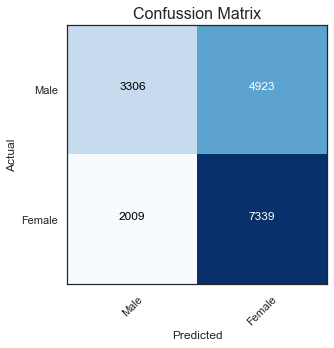

In [42]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("F1 - Score: ",round(2*(pre*rec/(pre+rec)),3))
print("Precision  : ", pre)

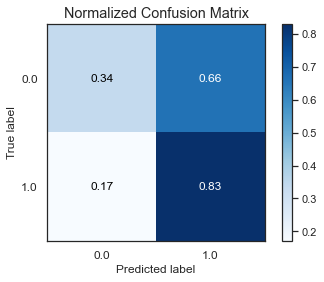

In [43]:
predictions = cross_val_predict(lr, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

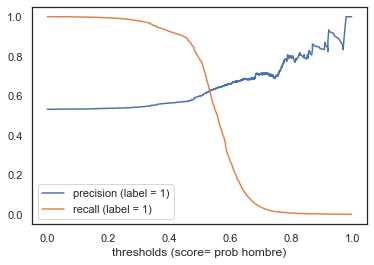

In [44]:
precision_recall_curve_hombre(y_test=ytest,y_proba=yproba)

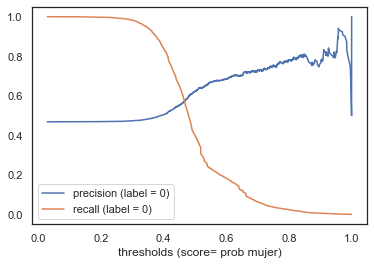

In [45]:
precision_recall_curve_mujer(y_test=ytest,y_proba=yproba)

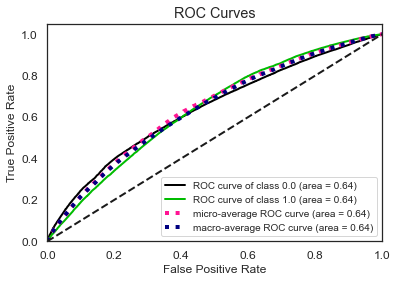

In [46]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(lr, Xtrain, ytrain,method='predict_proba')
skplt.metrics.plot_roc(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

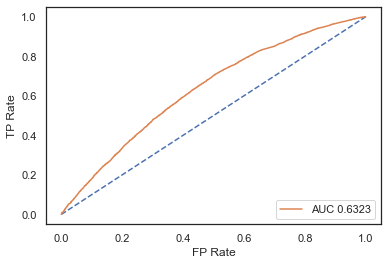

In [47]:
plot_roc(ytest,yproba)

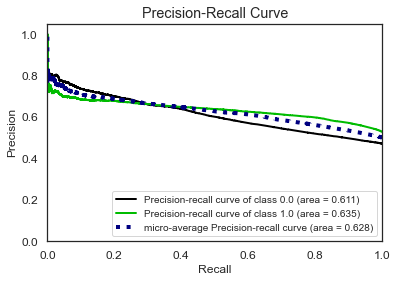

In [48]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
predictions_proba = cross_val_predict(lr, Xtrain, ytrain, method='predict_proba')
skplt.metrics.plot_precision_recall(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show();

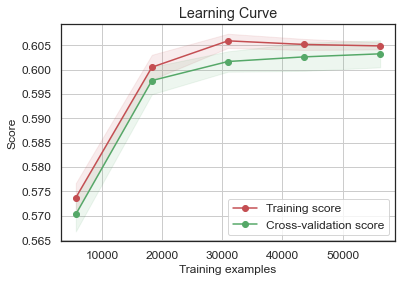

In [131]:
skplt.estimators.plot_learning_curve(lr, Xtrain, ytrain)
plt.show()

In [132]:
lr.coef_

array([[ 0.  , -0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.02,  0.  ,
         0.03,  0.  ,  0.  ,  0.01,  0.01,  0.01,  0.02,  0.01, -0.01,
        -0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.01,  0.  ,  0.  ,
         0.  ,  0.  ,  0.01,  0.  ,  0.03,  0.  , -0.01,  0.  ,  0.  ,
         0.  ,  0.  ,  0.02,  0.  ,  0.11,  0.  ,  0.08,  0.03,  0.01,
         0.  , -0.  ,  0.03,  0.03,  0.1 ,  0.01,  0.02,  0.06,  0.01,
         0.  ,  0.03,  0.02,  0.01,  0.05,  0.02, -0.19, -0.04, -0.09,
        -0.05, -0.01,  0.04, -0.01,  0.  ,  0.  ,  0.03, -0.08, -0.04,
         0.02,  0.02, -0.  ,  0.15, -0.01, -0.02,  0.  , -0.03, -0.14,
         0.01,  0.03, -0.07,  0.  ,  0.  ,  0.01,  0.01,  0.01,  0.03,
        -0.  ,  0.02, -0.06, -0.02,  0.  , -0.  , -0.01,  0.07,  0.09,
         0.05, -0.03, -0.05,  0.02,  0.  ,  0.  ,  0.03,  0.  ,  0.03,
         0.  , -0.07,  0.  ,  0.09,  0.  ,  0.  , -0.04,  0.09,  0.08,
         0.02]])

**Random Forest**

In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(3,12))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf=list(range(1,15))
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
hyperparameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [50]:
# First create the base model to tune
rf = RandomForestClassifier()
##Random Search replaces the exhaustive enumeration of all combinations by selecting them randomly.

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_best_model = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = hyperparameters,
                                   scoring='accuracy', 
                                   n_iter = 50, cv = 3, verbose=4, 
                                   random_state=42, n_jobs = -1) #chequear en que cambia n_jobs

# Fit the random search model
rf_best_model.fit(Xtrain, ytrain)

ypred = rf_best_model.predict(Xtest)
yproba = rf_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.0min finished


In [51]:
#Observo mejores parámetros elegidos
best_params=rf_best_model.best_params_
best_params

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 9,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Se utilizarán los mejores parámetros encontrados.

In [192]:
rf=RandomForestClassifier(n_estimators= 150, 
                          min_samples_split =2,
                          min_samples_leaf = 9, 
                          max_features = 'sqrt',
                          max_depth = None, 
                          bootstrap= True)
rf.fit(Xtrain, ytrain)

ypred = rf.predict(Xtest)
yproba = rf.predict_proba(Xtest)[:,1]

In [52]:
rf=RandomForestClassifier(n_estimators= best_params['n_estimators'], 
                          min_samples_split = best_params['min_samples_split'],
                          min_samples_leaf = best_params['min_samples_leaf'], 
                          max_features = best_params['max_features'],
                          max_depth = best_params['max_depth'], 
                          bootstrap= best_params['bootstrap'])
rf.fit(Xtrain, ytrain)

ypred = rf.predict(Xtest)
yproba = rf.predict_proba(Xtest)[:,1]

Accuracy  :  0.612
Recall  :  0.766
F1 - Score:  0.677
Precision  :  0.607


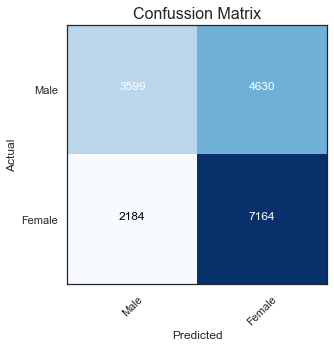

In [53]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("F1 - Score: ",round(2*(pre*rec/(pre+rec)),3))
print("Precision  : ", pre)

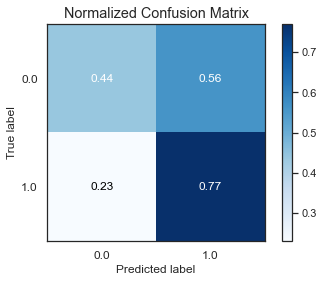

In [54]:
predictions = cross_val_predict(rf, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

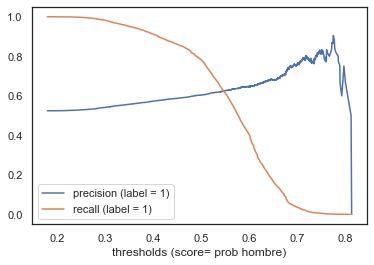

In [139]:
precision_recall_curve_hombre(y_test=ytest,y_proba=yproba)

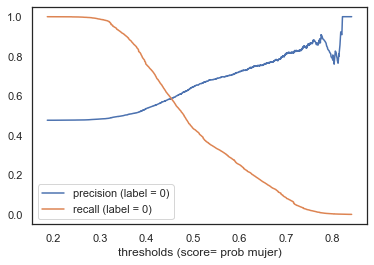

In [140]:
precision_recall_curve_mujer(y_test=ytest,y_proba=yproba)

In [55]:
predictions_proba = cross_val_predict(rf, Xtrain, ytrain,method='predict_proba')
predictions_proba

array([[0.59, 0.41],
       [0.68, 0.32],
       [0.46, 0.54],
       ...,
       [0.57, 0.43],
       [0.4 , 0.6 ],
       [0.63, 0.37]])

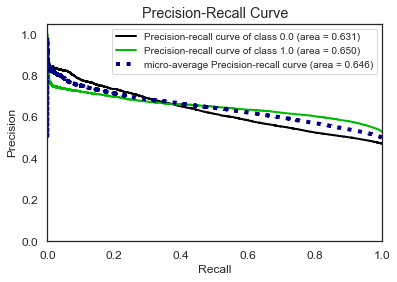

In [56]:
#grafico de curva presicion recall
skplt.metrics.plot_precision_recall(ytrain, predictions_proba) 
plt.legend(loc=0,prop={'size':10})
# detalles de cómo cambiar la leyenda en matplotlib https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.show()

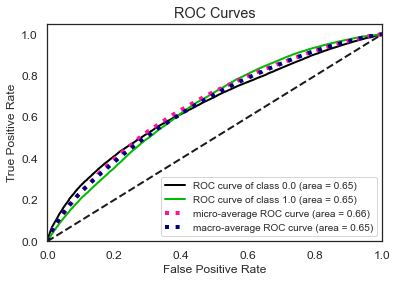

In [57]:
#Para ver con QUÉ probabilidades predijo a cada observacion en 1 o 0
#predictions_proba = cross_val_predict(rf, Xtrain, ytrain, method='predict_proba')
skplt.metrics.plot_roc(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

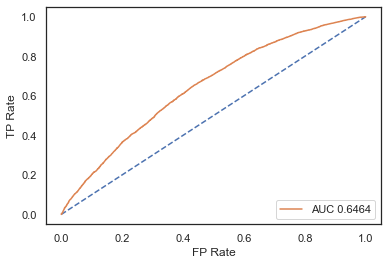

In [58]:
plot_roc(ytest,yproba)

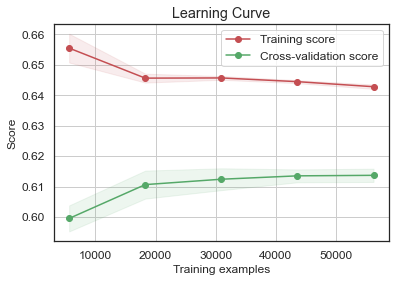

In [145]:
skplt.estimators.plot_learning_curve(rf, Xtrain, ytrain)
plt.show()

In [60]:
rf_fit = rf_best_model.best_estimator_

*Feature Importance*

Feature ranking:
1. feature 34 (0.078900) -> ambito
2. feature 38 (0.068813) -> buenosaires
3. feature 69 (0.059919) -> zonajobs
4. feature 39 (0.059754) -> bumeran
5. feature 70 (0.054331) -> zonaprop
6. feature 46 (0.052498) -> disco
7. feature 49 (0.051634) -> futbollibre
8. feature 2 (0.038022) -> navegador_Firefox
9. feature 67 (0.035522) -> veadigital
10. feature 42 (0.034359) -> creditosparatodos
11. feature 43 (0.033616) -> cronista
12. feature 32 (0.030263) -> Otros
13. feature 52 (0.023244) -> infotechnology
14. feature 20 (0.023082) -> domain_type_Alimentos
15. feature 55 (0.021884) -> movistar
16. feature 53 (0.020116) -> jumbo
17. feature 36 (0.019526) -> ausa
18. feature 0 (0.019525) -> OS_Android
19. feature 59 (0.019477) -> pronto
20. feature 66 (0.018718) -> toyota
21. feature 15 (0.016362) -> VOS_Windows 10
22. feature 3 (0.014262) -> navegador_SocialApp
23. feature 37 (0.013851) -> autocosmos
24. feature 51 (0.012178) -> gba
25. feature 18 (0.011535) -> marca_Samsung

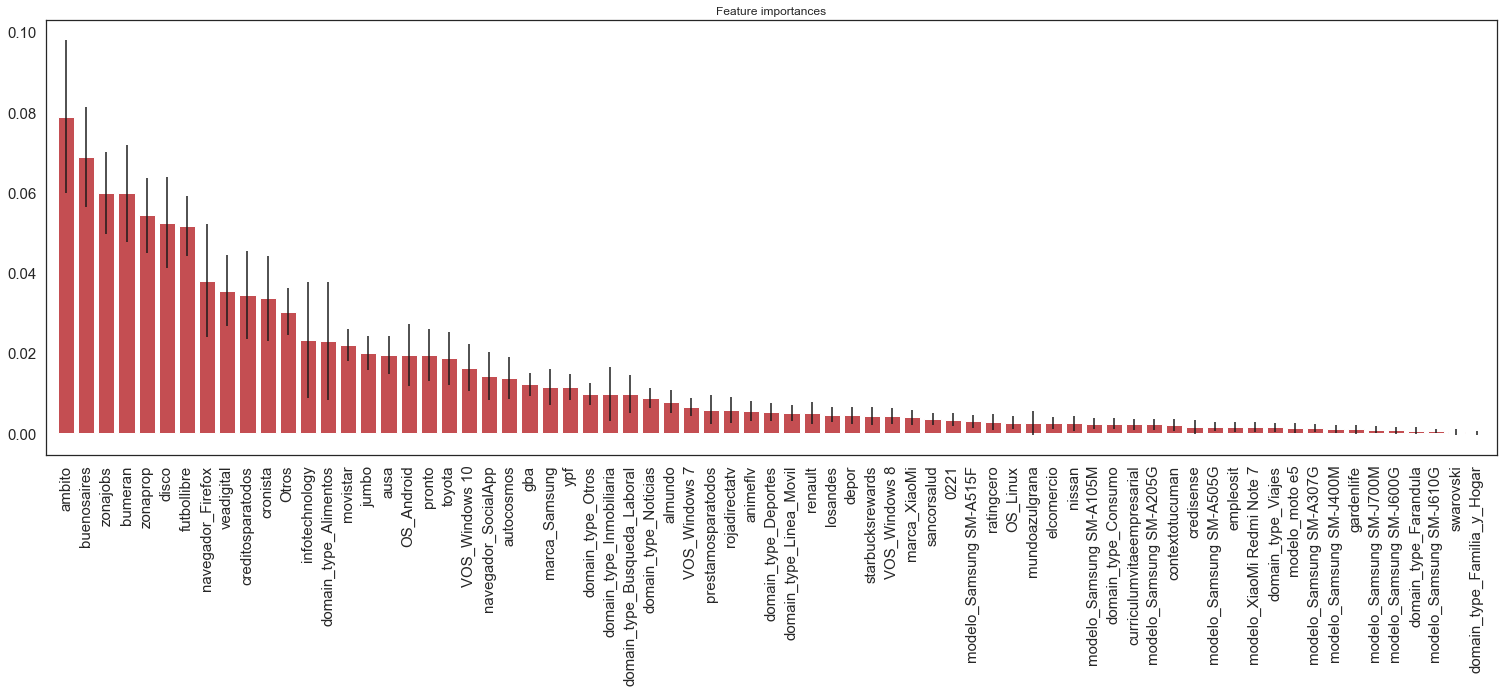

In [62]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf_fit.feature_importances_ #rf
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

variables=cols
variables_ordenadas=[]

for i in range(0,len(indices)): #TENES IDEA PORQUE NO ME TOMA  range(0,len(indices) ?
    variables_ordenadas.append(variables[indices[i]])
# Print the feature ranking
print("Feature ranking:")

for f in range(0,len(indices)):
    #print("feature {} {} --> {}").format(indices[f], importances[indices[f]], variables_ordenadas[f])
    print("%d. feature %d (%f) -> %s" % (f + 1, indices[f], importances[indices[f]],variables_ordenadas[f]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(26,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), variables_ordenadas)
plt.xlim([-1, X.shape[1]])

x = plt.gca().xaxis
#One specific to text is the set rotation function which changes the rotation based on degrees.
# rotate the tick labels for the x axis
for item in x.get_ticklabels():
    item.set_rotation(90)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=15)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(15)    

plt.show()

**XG Boost**

In [63]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

one_to_left = st.beta(10, 1) #  This distribution will return values between 0 and 1, nearer to 1 #WARNING, NO TENGO CLASES DESB

max_depth = list(range(3,12))
max_depth.append(None)

hyperparameters = {  
    "n_estimators": st.randint(50,200), # Number of boosted trees to fit.
    "max_depth": max_depth,     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

xgb_best_model = RandomizedSearchCV(estimator = model_xgb, 
                            param_distributions = hyperparameters,
                            scoring='accuracy', #check
                            n_iter = 50, cv = 3, verbose=4, 
                            random_state=42, n_jobs = -1)
xgb_best_model.fit(Xtrain, ytrain)

ypred = xgb_best_model.predict(Xtest) 
yproba = xgb_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:32:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
best_params=xgb_best_model.best_params_
best_params

{'colsample_bytree': 0.9363452853279312,
 'gamma': 0.8328441119525964,
 'learning_rate': 0.08668165890339244,
 'max_depth': 11,
 'min_child_weight': 12.074061046916015,
 'n_estimators': 102,
 'reg_alpha': 7.965790437258485,
 'subsample': 0.9909933847706478}

Se utilizarán los mejores parámetros encontrados.

In [65]:
xgboost = xgb.XGBClassifier(n_jobs=-1,
                            colsample_bytree = best_params['colsample_bytree'],
                            gamma= best_params['gamma'],
                            learning_rate= best_params['learning_rate'],
                            max_depth = best_params['max_depth'],
                            min_child_weight= best_params['min_child_weight'],
                            n_estimators= best_params['n_estimators'],
                            reg_alpha= best_params['reg_alpha'],
                            subsample= best_params['subsample'])

xgboost.fit(Xtrain, ytrain)


ypred = xgboost.predict(Xtest)
yproba = xgboost.predict_proba(Xtest)[:,1]

[17:47:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Accuracy  :  0.615
Recall  :  0.751
F1 - Score:  0.674
Precision  :  0.612


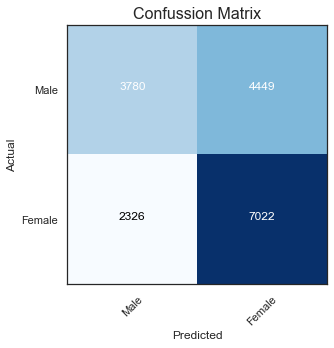

In [66]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['Male','Female'], #classes=['No','Yes']
                      title='Confussion Matrix')

tn, fp, fn, tp = cnf_matrix.ravel()
# measures :
tn, fp, fn, tp = cnf_matrix.ravel()
acc = round((tp + tn) / (tp + tn + fn + fp),3)
rec = round(tp / (tp + fn),3)
tnr = round(tn / (fp + tn),3)
pre = round(tp/(tp + fp), 3)
print("Accuracy  : ", acc)
print("Recall  : ", rec)
print("F1 - Score: ",round(2*(pre*rec/(pre+rec)),3))
print("Precision  : ", pre)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:53:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:53:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

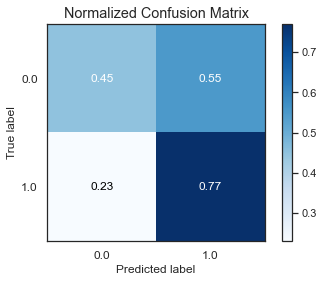

In [67]:
predictions = cross_val_predict(xgboost, X, y)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

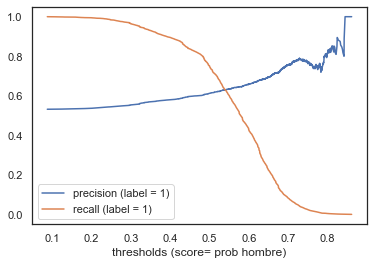

In [68]:
precision_recall_curve_hombre(y_test=ytest,y_proba=yproba)

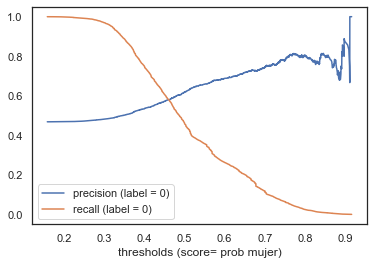

In [69]:
precision_recall_curve_mujer(y_test=ytest,y_proba=yproba)

In [70]:
predictions_proba = cross_val_predict(xgboost, Xtrain, ytrain,method='predict_proba')
predictions_proba

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:54:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:54:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:54:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

array([[0.58, 0.42],
       [0.69, 0.31],
       [0.46, 0.54],
       ...,
       [0.58, 0.42],
       [0.36, 0.64],
       [0.66, 0.34]], dtype=float32)

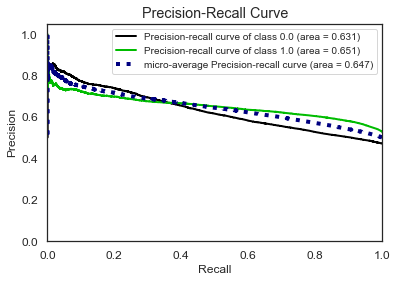

In [71]:
skplt.metrics.plot_precision_recall(ytrain, predictions_proba)
plt.legend(loc=0,prop={'size':10})
# detalles de cómo cambiar la leyenda en matplotlib https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.show()

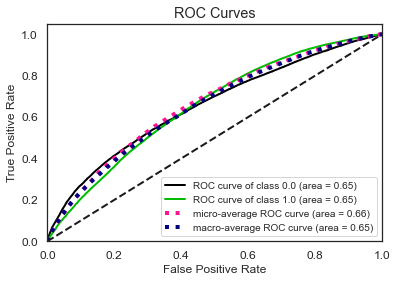

In [72]:
skplt.metrics.plot_roc(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

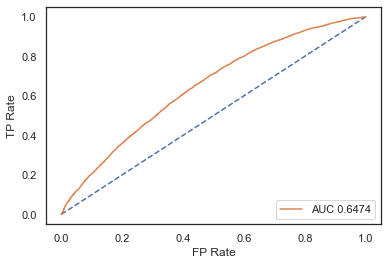

In [73]:
plot_roc(ytest,yproba)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:19:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

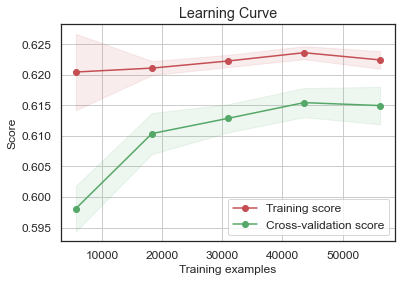

In [161]:
skplt.estimators.plot_learning_curve(xgboost, Xtrain, ytrain)
plt.show()

In [74]:
features = X.columns.tolist()#eature_index.feature.tolist() + ga_columns

df_importance = pd.DataFrame({"importance": xgboost.feature_importances_,
                              "feature": features
                             }).sort_values("importance", ascending=False)
df_importance

,importance,feature
34,0.177673,ambito
2,0.081775,navegador_Firefox
42,0.074199,creditosparatodos
49,0.046456,futbollibre
36,0.041374,ausa
59,0.036336,pronto
52,0.034797,infotechnology
66,0.032162,toyota
37,0.027073,autocosmos
62,0.022249,rojadirectatv


In [200]:
xgboost.importance_type

'gain'

Text(0.5, 0, 'Xgboost Feature Importance')

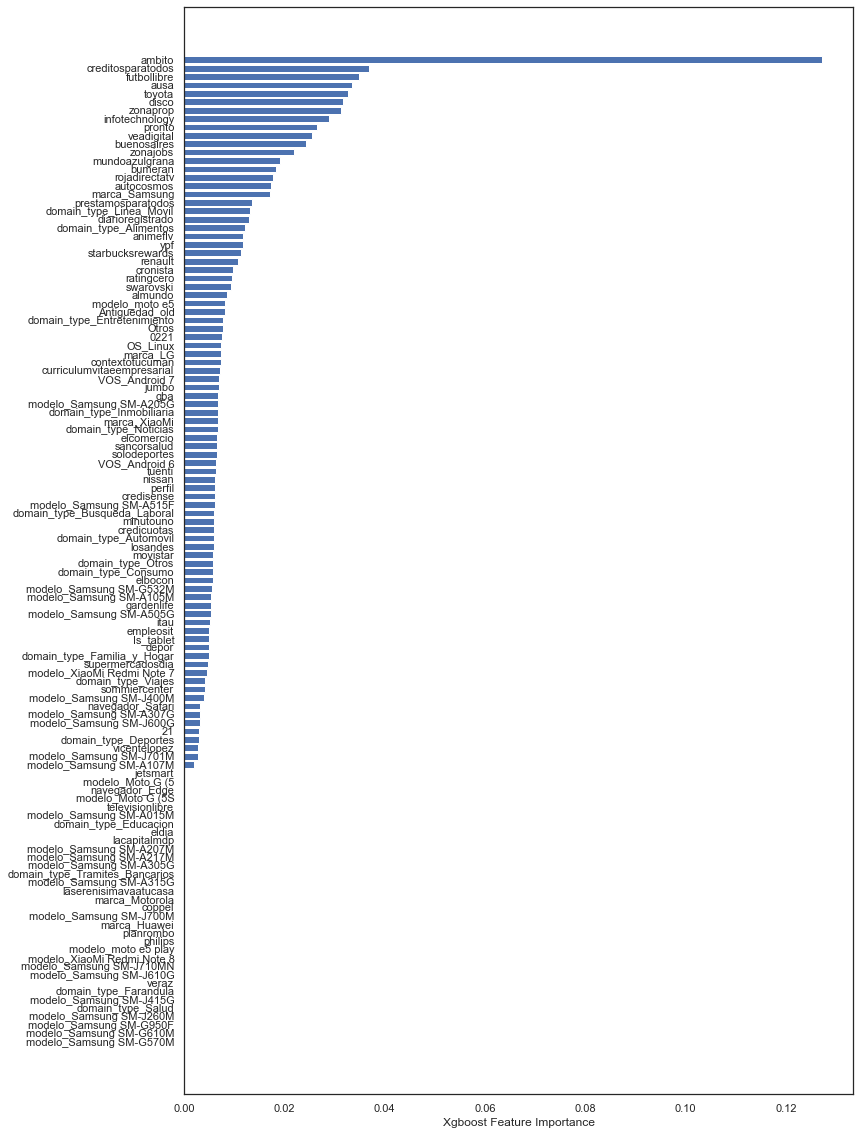

In [215]:
sorted_idx = xgboost.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (12,20)
plt.barh(X.columns[sorted_idx], xgboost.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

#plt.barh(X.columns, xgboost.feature_importances_)

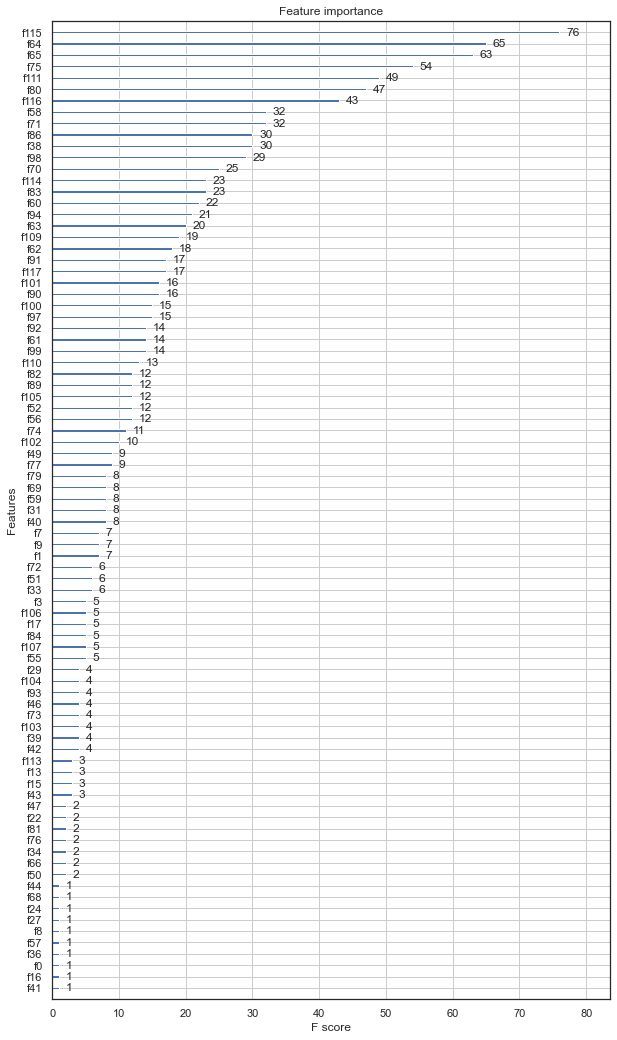

In [209]:
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plt.rcParams["figure.figsize"] = (10,18)
plot_importance(xgboost)
pyplot.show()

In [198]:
df_importance.head(30)

,importance,feature
60,0.127059,ambito
70,0.036974,creditosparatodos
80,0.034812,futbollibre
62,0.033546,ausa
109,0.032663,toyota
75,0.031725,disco
116,0.031232,zonaprop
83,0.028844,infotechnology
98,0.026496,pronto
111,0.025500,veadigital


**Cuadro comparativo de métricas**

|Modelos | Accuracy | AUC | Recall | Precisión | F1-Score |   
|--|--|--|--|--|--|   
|Baseline| 0.579 | 0.605 | **0.823** | 0.567 | 0.672|  
|Logistic Regression| 0.608 | 0.632 | 0.798 | 0.594 | **0.682** |  
|**Random Forrest** | 0.616 | 0.646 | 0.779 | 0.604 | 0.681 |   
|XGBoost | **0.617** | **0.65** | 0.771 |  **0.605** | 0.679 |   

La siguiente tabla que compara distintas métricas en los distintos modelos.
Se observa que el modelo de XGBoost funcionan mejor que el resto.